reference = https://www.kaggle.com/code/saideepakdepally/ids-using-cnn-lstm/notebook#Training-the-model 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
dfs = []
for i in range(1,3):
    path = "archive/UNSW_NB15_{}.parquet".format(i)
    dfs.append(pd.read_parquet(path))
combined_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [4]:
combined_data.head(10)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.093750,1.803636e+08,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000000,8.810000e+08,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.000000,8.544000e+08,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.656250,6.000000e+08,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.000000,8.504000e+08,...,0,0,2,1,0,0,0,0,Normal,0
5,0.000003,udp,-,INT,2,0,784,0,333333.312500,1.045333e+09,...,0,0,2,1,0,0,0,0,Normal,0
6,0.000006,udp,-,INT,2,0,1960,0,166666.656250,1.306667e+09,...,0,0,2,1,0,0,0,0,Normal,0
7,0.000028,udp,-,INT,2,0,1384,0,35714.285156,1.977143e+08,...,0,0,1,1,0,0,0,0,Normal,0
8,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,2,2,0,0,0,1,Normal,0
9,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,2,2,0,0,0,1,Normal,0


In [5]:
print(combined_data.columns)

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'attack_cat', 'label'],
      dtype='object')


In [6]:
combined_data['state'].value_counts()

state
FIN    117164
INT    116438
CON     20134
REQ      3833
RST        84
ECO        12
ACC         4
CLO         1
PAR         1
URN         1
no          1
Name: count, dtype: int64

In [7]:
combined_data['attack_cat'].value_counts()

attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64

In [8]:
combined_data.shape

(257673, 36)

In [9]:
combined_data.duplicated().sum()

112451

In [10]:
subset_cols = combined_data.columns.difference(['attack_cat']).tolist()
duplicate_sig = combined_data.duplicated(subset=subset_cols, keep=False) #identify duplicates based on all columns except 'attack_cat'

consistent_attack_cat = combined_data.groupby(subset_cols)['attack_cat'].transform(lambda x: x.nunique() == 1)
#group by the subset columns and check if 'attack_cat' is consistent within each group

combined_data = combined_data[~duplicate_sig | (duplicate_sig & consistent_attack_cat)]
#filter rows and keep rows that are either: not duplicates, or duplicates with consistent 'attack_cat' values

C:\Users\sehat\AppData\Local\Temp\ipykernel_6008\1714932844.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consistent_attack_cat = combined_data.groupby(subset_cols)['attack_cat'].transform(lambda x: x.nunique() == 1)


In [11]:
combined_data.duplicated().sum()

80597

In [12]:
combined_data.shape

(218321, 36)

In [13]:
combined_data['attack_cat'].value_counts()

attack_cat
Normal            93000
Generic           58450
Exploits          27973
Fuzzers           21263
Reconnaissance    11496
DoS                3634
Shellcode          1383
Analysis            616
Backdoor            352
Worms               154
Name: count, dtype: int64

In [152]:
combined_data['proto'].value_counts()

proto
tcp     122528
udp      91775
arp       3846
ospf       108
igmp        48
icmp        15
rtp          1
Name: count, dtype: int64

In [14]:
combined_data['is_ftp_login'].value_counts()

is_ftp_login
0    215079
1      3216
4        16
2        10
Name: count, dtype: int64

In [15]:
combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])

In [16]:
combined_data['is_ftp_login'].value_counts()

is_ftp_login
0    215079
1      3242
Name: count, dtype: int64

In [17]:
combined_data['service'].value_counts()

service
-           102621
dns          68624
http         26544
smtp          6895
ftp-data      5391
ftp           4974
pop3          1528
ssh           1506
ssl             86
snmp            59
dhcp            42
irc             30
radius          21
Name: count, dtype: int64

In [18]:
combined_data['service'] = combined_data['service'].apply(lambda x:"None" if x=='-' else x)

In [19]:
combined_data['service'].value_counts()

service
None        102621
dns          68624
http         26544
smtp          6895
ftp-data      5391
ftp           4974
pop3          1528
ssh           1506
ssl             86
snmp            59
dhcp            42
irc             30
radius          21
Name: count, dtype: int64

In [20]:
combined_data.shape

(218321, 36)

In [21]:
combined_data.drop(columns=['label'],inplace=True) #I want prediction of the attack type not generic of whether it's an attack or not

In [22]:
train, test = train_test_split(combined_data,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)

In [23]:
x_train, y_train = train.drop(columns=['attack_cat']), train[['attack_cat']]
x_test, y_test = test.drop(columns=['attack_cat']), test[['attack_cat']]
x_val, y_val = val.drop(columns=['attack_cat']), val[['attack_cat']]

x_train.shape, y_train.shape

((139724, 34), (139724, 1))

In [24]:
x_test.shape, y_test.shape

((43665, 34), (43665, 1))

In [25]:
x_val.shape, y_val.shape

((34932, 34), (34932, 1))

In [26]:
y_train['attack_cat'].value_counts()

attack_cat
Normal            59433
Generic           37542
Exploits          17959
Fuzzers           13577
Reconnaissance     7289
DoS                2356
Shellcode           875
Analysis            390
Backdoor            207
Worms                96
Name: count, dtype: int64

In [27]:
y_val['attack_cat'].value_counts()

attack_cat
Normal            14915
Generic            9330
Exploits           4450
Fuzzers            3417
Reconnaissance     1834
DoS                 565
Shellcode           233
Analysis             98
Backdoor             65
Worms                25
Name: count, dtype: int64

In [28]:
y_test['attack_cat'].value_counts()

attack_cat
Normal            18652
Generic           11578
Exploits           5564
Fuzzers            4269
Reconnaissance     2373
DoS                 713
Shellcode           275
Analysis            128
Backdoor             80
Worms                33
Name: count, dtype: int64

In [29]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218321 entries, 0 to 257672
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                218321 non-null  float32 
 1   proto              218321 non-null  object  
 2   service            218321 non-null  category
 3   state              218321 non-null  object  
 4   spkts              218321 non-null  int16   
 5   dpkts              218321 non-null  int16   
 6   sbytes             218321 non-null  int32   
 7   dbytes             218321 non-null  int32   
 8   rate               218321 non-null  float32 
 9   sload              218321 non-null  float32 
 10  dload              218321 non-null  float32 
 11  sloss              218321 non-null  int16   
 12  dloss              218321 non-null  int16   
 13  sinpkt             218321 non-null  float32 
 14  dinpkt             218321 non-null  float32 
 15  sjit               218321 non-null  flo

In [30]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

In [31]:
print(train[cat_col].dtypes)

proto        object
service    category
state        object
dtype: object


In [32]:
print(train[num_col].dtypes)

sbytes                 int32
dloss                  int16
ct_dst_sport_ltm        int8
dur                  float32
ct_flw_http_mthd        int8
dmean                  int16
sload                float32
synack               float32
dload                float32
sinpkt               float32
rate                 float32
sjit                 float32
spkts                  int16
swin                   int16
trans_depth            int16
tcprtt               float32
ct_src_dport_ltm        int8
dinpkt               float32
smean                  int16
dpkts                  int16
sloss                  int16
dbytes                 int32
is_sm_ips_ports         int8
dwin                   int16
is_ftp_login            int8
ct_ftp_cmd              int8
dtcpb                  int64
djit                 float32
ackdat               float32
response_body_len      int32
stcpb                  int64
dtype: object


In [33]:
print(set(x_val['state'].unique()) - set(x_train['state'].unique()))
print(set(x_test['state'].unique()) - set(x_train['state'].unique()))


{'no', 'CLO'}
set()


In [34]:
x_val = x_val[~x_val['state'].isin(['no', 'CLO'])]
y_val = y_val.loc[x_val.index] #ensure y_val matches the new x_val indices

In [35]:
print(x_train[cat_col].dtypes)

proto        object
service    category
state        object
dtype: object


In [36]:
print(x_val[cat_col].dtypes)

proto        object
service    category
state        object
dtype: object


In [37]:
print(x_test[cat_col].dtypes)

proto        object
service    category
state        object
dtype: object


In [38]:
x_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,smean,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports
238546,0.000003,udp,dns,INT,2,0,114,0,333333.312500,1.520000e+08,...,57,0,0,0,29,16,0,0,0,0
87397,0.118105,tcp,None,RST,6,2,258,86,59.269295,1.456331e+04,...,43,43,0,0,8,1,0,0,0,0
148810,0.557324,tcp,None,FIN,14,8,5554,746,37.680058,7.403952e+04,...,397,93,0,0,1,1,0,0,0,0
26264,0.133143,tcp,None,FIN,96,98,5486,92746,1449.569336,3.262057e+05,...,57,946,0,0,1,1,0,0,0,0
82477,0.016974,tcp,None,FIN,16,18,1540,1644,1944.149902,6.805702e+05,...,96,91,0,0,6,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72357,0.000008,udp,None,INT,2,0,78,0,125000.000000,3.900000e+07,...,39,0,0,0,1,1,0,0,0,0
63769,0.349402,udp,None,CON,2,2,120,590,8.586098,1.373776e+03,...,60,295,0,0,1,1,0,0,0,0
98103,0.001053,udp,dns,CON,2,2,130,162,2849.002930,4.938272e+05,...,65,81,0,0,4,2,0,0,0,0
123972,2.331945,tcp,None,FIN,30,14,21842,728,18.439543,7.243396e+04,...,728,52,0,0,1,1,0,0,0,0


In [39]:
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=False), cat_col),  #one-hot encode categorical features
        ('scaler', StandardScaler(), num_col)  #standard scale numeric features
    ],
)

In [40]:
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)
x_val = ct.transform(x_val)

In [154]:
encoder = ct.named_transformers_['encoder']
scaler = ct.named_transformers_['scaler']

In [156]:
import joblib
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
#will need these later to use model in other program

['scaler.pkl']

In [41]:
x_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.54280093,
        -0.04281068, -0.83766329],
       [ 0.        ,  0.        ,  0.        , ...,  0.53397629,
        -0.04281068,  0.06894309],
       [ 0.        ,  0.        ,  0.        , ...,  0.31847186,
        -0.04281068,  1.90340902],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.54280093,
        -0.04281068, -0.83766329],
       [ 0.        ,  0.        ,  0.        , ...,  1.16395839,
        -0.04281068, -0.74916485],
       [ 0.        ,  0.        ,  0.        , ..., -0.54280093,
        -0.04281068, -0.83766329]])

In [42]:
y_train['attack_cat'].value_counts()

attack_cat
Normal            59433
Generic           37542
Exploits          17959
Fuzzers           13577
Reconnaissance     7289
DoS                2356
Shellcode           875
Analysis            390
Backdoor            207
Worms                96
Name: count, dtype: int64

In [43]:
from imblearn.combine import SMOTETomek
from collections import Counter

smote_tomek = SMOTETomek(sampling_strategy={
    "Analysis": 2000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 1000  
}, random_state=42)

#apply SMOTE-Tomek to the training data
x_train_resampled, y_train_resampled = smote_tomek.fit_resample(x_train, y_train)

print("Original class distribution:", y_train['attack_cat'].value_counts())
print()
print("Resampled class distribution:", y_train_resampled['attack_cat'].value_counts())

C:\Users\sehat\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\sehat\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\sehat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn

Original class distribution: attack_cat
Normal            59433
Generic           37542
Exploits          17959
Fuzzers           13577
Reconnaissance     7289
DoS                2356
Shellcode           875
Analysis            390
Backdoor            207
Worms                96
Name: count, dtype: int64

Resampled class distribution: attack_cat
Normal            56271
Generic           37284
Exploits          15958
Fuzzers           10957
Reconnaissance     6138
Analysis           1955
Backdoor           1898
Shellcode          1771
DoS                1519
Worms               951
Name: count, dtype: int64


In [44]:
attacks = y_train['attack_cat'].unique()

In [45]:
attacks

['Generic', 'Normal', 'Fuzzers', 'Exploits', 'Reconnaissance', 'DoS', 'Shellcode', 'Worms', 'Analysis', 'Backdoor']
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']

In [46]:
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[attacks],sparse_output=False), ['attack_cat'])])
y_train_resampled = np.array(ct1.fit_transform(y_train_resampled))
y_test = np.array(ct1.transform(y_test))
y_val = np.array(ct1.transform(y_val))

In [47]:
del train
del test
del x_train
del y_train

In [48]:
y_train_resampled

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

In [50]:
n_features = x_train_resampled.shape[1]  

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features,1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(units=64, return_sequences=True))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(units=64, return_sequences=True))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(units=128))

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

C:\Users\sehat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 29, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 13, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,514 (1.42 MB)

 Trainable params: 372,618 (1.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
def create_model():
    n_features = x_train_resampled.shape[1]  

    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(units=64, return_sequences=True))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())  
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(units=64, return_sequences=True))

    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(units=128))

    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

In [52]:
model = create_model()

history = model.fit(x_train_resampled, y_train_resampled, epochs=5, batch_size=256, validation_data=(x_val, y_val))

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Epoch 1/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 106s 159ms/step - accuracy: 0.7847 - loss: 0.7778 - precision_1: 0.8950 - recall_1: 0.6778 - val_accuracy: 0.7451 - val_loss: 0.8147 - val_precision_1: 0.9177 - val_recall_1: 0.6488
Epoch 2/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.8573 - loss: 0.4418 - precision_1: 0.9028 - recall_1: 0.8134 - val_accuracy: 0.8472 - val_loss: 0.4220 - val_precision_1: 0.8891 - val_recall_1: 0.8041
Epoch 3/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.8691 - loss: 0.3796 - precision_1: 0.9069 - recall_1: 0.8319 - val_accuracy: 0.8441 - val_loss: 0.4065 - val_precision_1: 0.8853 - val_recall_1: 0.8084
Epoch 4/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 85s 162ms/step - accuracy: 0.8743 - loss: 0.3458 - precision_1: 0.9063 - recall_1: 0.8417 - val_accuracy: 0.8514 - val_loss: 0.3936 - val_precision_1: 0.8858 - val_recall_1: 0.8142
Epoch 5/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 81s 153ms/step - accuracy: 0.8776 - loss: 0.3260 - precision_1: 0.9093 - recall_

In [144]:
y_pred = model.predict(x_test)

1365/1365 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


In [146]:
from sklearn.metrics import confusion_matrix

y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels) 

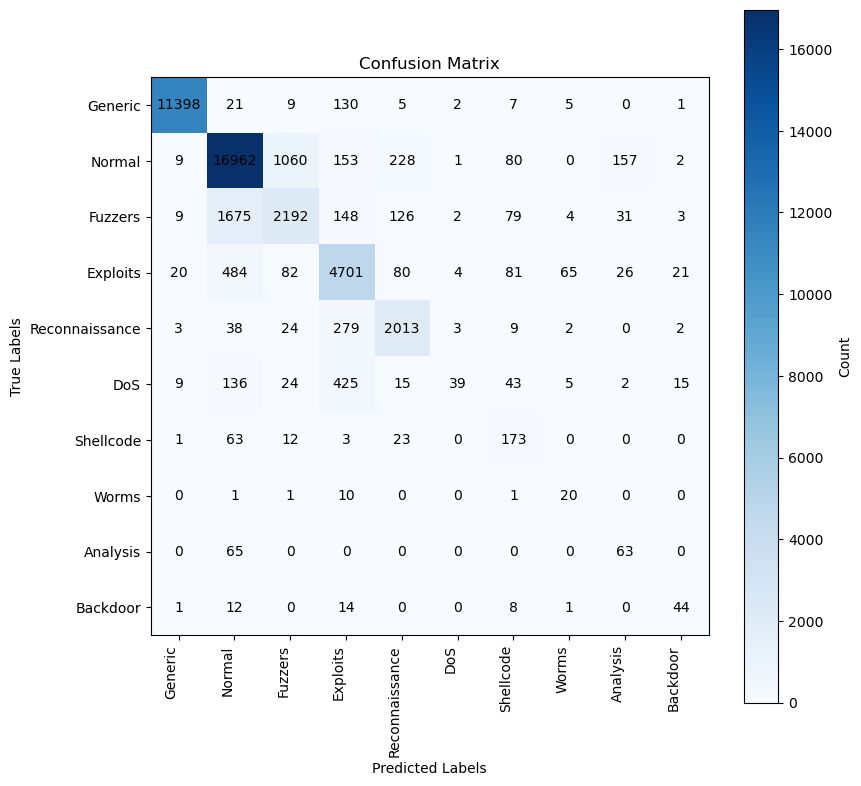

In [148]:
class_names = attacks

plt.figure(figsize=(9, 9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Count')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=10)
plt.xticks(range(len(class_names)), class_names, rotation=90, ha='right')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

In [56]:
model.save('687584.keras')

In [134]:
from tensorflow.keras.models import load_model

model = load_model("687584.keras")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 58, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 29, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 13, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 11, 256)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,118,752 (4.27 MB)

 Trainable params: 372,618 (1.42 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 745,238 (2.84 MB)

In [150]:
original_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

index_to_label = {i: label for i, label in enumerate(original_labels)}

print("Index to Label mapping:")
for index, label in index_to_label.items():
    print(f"{index} => {label}")
import pickle
with open('index_to_label_map.pkl', 'wb') as f:
    pickle.dump(index_to_label, f)

#will need this to decode model outputs in other program

Index to Label mapping:
0 => Normal
1 => Generic
2 => Exploits
3 => Fuzzers
4 => DoS
5 => Reconnaissance
6 => Analysis
7 => Backdoor
8 => Shellcode
9 => Worms
